### <center><font size=5> (Bio)statistics in R: Part #2</font></center>

***

**author**: Ruslan Klymentiev

**date**: XX August, 2018

![](https://image.ibb.co/hiisWK/pexels_photo_935869.jpg)

***Link to part #1.***

- <a href='#intro'>Project Introduction</a>  
- <a href='#setup'>Setting up the Environment</a>
- <a href='#probthnk'>Probabilistic Thinking</a>
 - <a href='#exp'>Experiments</a>
 - <a href='#prob'>Probability</a>
 - <a href='#rv'>Random Variables</a>
 - <a href='#chardist'>Main Characteristics of Distribution</a>
 - <a href='#condprob'>Conditional Probability</a>
 - <a href='#bayes'>Bayes Rule</a>
 - <a href='#roc'>ROC and AUC</a>
- <a href='#stroke'>Healthcare Dataset Stroke Data</a>
 - <a href='#eda'>EDA (Exploratory Data Analysis)</a> 
 - <a href='#outcome'>Test Outcome Analysis</a> 
- <a href='#nextpart'>What to Expect Next</a>

First of all, I want to say thank for your feedback and positive comments. I really hope that first part was worth reading.

So now we know what is probability, difference between sample and population, we can calculate main characterictics of distribution and explore them through visualization. Also we covered how to explore test results using probabilistic thinking and Bayes Rule. 

In this part we will focus on how make decisions about population based on the information of sample.

## <a id='setup'>Setting up the environment</a> 

In [4]:
suppressMessages(library(tidyverse))
suppressMessages(library(repr))
suppressMessages(library(cowplot))
set.seed(123)
options(repr.plot.width=7, repr.plot.height=3)

In [102]:
Stroke_Data <- read.csv("healthcare-dataset-stroke-data/train_2v.csv")

# some data cleaning
Stroke_Data <- Stroke_Data %>% filter(gender != "Other" & !(is.na(bmi))) %>%
  select(-id)

# convert some variables to a factor
Stroke_Data$hypertension <- as.factor(Stroke_Data$hypertension)
Stroke_Data$heart_disease <- as.factor(Stroke_Data$heart_disease)
Stroke_Data$stroke <- as.factor(Stroke_Data$stroke)

sample_n(Stroke_Data, 5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
20702,Male,49,0,0,Yes,Govt_job,Rural,128.04,31.1,never smoked,0
34964,Male,77,0,0,Yes,Self-employed,Urban,100.29,31.2,smokes,0
19317,Male,42,0,0,Yes,Private,Urban,81.89,42.8,smokes,0
29660,Male,75,0,0,Yes,Private,Rural,81.76,32.4,never smoked,0
20571,Female,64,0,0,Yes,Self-employed,Urban,209.38,47.7,never smoked,0


## Likelihood

**Likelihood** is a tool for summarizing the data’s evidence about unknown parameters. The likelohood of a collection of data is the joint density evaluated as a function of the unknown parameters with the data fixed.

Given a statistical probability mass function or density, say $f(x,\theta)$, where $\theta$ is unkown parameter, the likelihood $L$ is $f$ viewed as a function of $\theta$ for a fixed observed values of $x$.

Example:

We have a coin chance of getting heads $\theta$ which falls under binomial distribution.
\begin{align}
f(x,\theta) = \theta^x(1-\theta)^{1-x}, \theta \in [0;1]
\end{align}

$x$ is either tails (0) or heads (1). We flip a coin and the result was heads (1). The likelihood is:
\begin{align}
L(\theta,1) = \theta^1(1-\theta)^{1-1}, \theta \in [0;1]
\end{align}
Now we want to find likelihood that our coin is fair ($\theta=.5$) vs coin is unfair (say, $\theta=.25$).
\begin{align}
\frac{L(0.5,1)}{L(0.25,1)}=\frac{1/2}{1/4}=2
\end{align}
Conclusion - there os twice as much evidence supporting the hypothesis that coin is fair ($\theta=.5$) to the hypothesis that coin is unfair ($\theta=.25$).

## Approximation results and confidence intervals

### Law of Large Numbers

>In probability theory, the **law of large numbers (LLN)** is a theorem that describes the result of performing the same experiment a large number of times. According to the law, the average of the results obtained from a large number of trials should be close to the expected value, and will tend to become closer as more trials are performed.

> *Source: [Wikipedia](https://en.wikipedia.org/wiki/Law_of_large_numbers)*

Imagine we are running an experiment to check the ratio of people with and w/o **Hypertension**. We assume that ratio from this dataset is true ratio of population. Then we take the sample of Hypertension results and check whether the difference between ratio of the sample and ratio of population is going to zero after bigger sample size.

In [288]:
print(paste0("Ratio of people with Hypertension in population: ", round(mean(Stroke_Data$hypertension == 1),3)))

[1] "Ratio of people with Hypertension in population: 0.088"


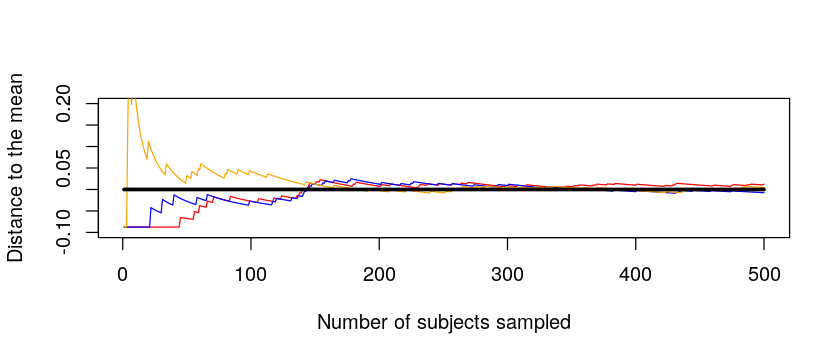

In [289]:
n <- 500 # size of the samples

# covert hypertension column to string on (0,1 integers)
hypertension  <- as.numeric(levels(Stroke_Data$hypertension))[Stroke_Data$hypertension]

avg_value <- mean(hypertension)

# taking three random sample n-size each
x1 = sample(hypertension, size = n, replace = F)
x2 = sample(hypertension, size = n, replace = F)
x3 = sample(hypertension, size = n, replace = F)

# creating three vectors that will hold information about ratio for each size of sample (from 1 to n)
xbar1 = rep(0,length(x1))
xbar2 = rep(0,length(x2))
xbar3 = rep(0,length(x3))

for (i in 1:length(x1)) {
    xbar1[i] = mean(x1[1:i])
    xbar2[i] = mean(x2[1:i])
    xbar3[i] = mean(x3[1:i])
}

plot(1:n, xbar1-avg_value, type="l", col="red", lwd=1, ylim=c(-0.1,0.2),
     xlab="Number of subjects sampled",
     ylab="Distance to the mean")
lines(1:n, xbar2-avg_value, col="blue", lwd=1)
lines(1:n, xbar3-avg_value, col="orange", lwd=1)
lines(1:n, rep(0,n), lwd=3)

We can see, that the higher the number of subjects in our samples, the more likely mean of the sample is going to equal to the mean of population.

The **law of large numbers** will establish that as *n* increases the averages are close to the target, while the
**central limit theorem** will say how close and with what probability are the results of the experiment to the
true target.

### Central Limit Theorem

> The **Central Limit Theorem** states that the sampling distribution of the sample means approaches a normal distribution as the sample size gets larger — no matter what the shape of the population distribution. This fact holds especially true for sample sizes over 30. All this is saying is that as you take more samples, especially large ones, your graph of the sample means will look more like a normal distribution.

> *Source: [StatisticsHowTo](http://www.statisticshowto.com/probability-and-statistics/normal-distributions/central-limit-theorem-definition-examples/)*

Let's look at the distribution of the **BMI** of people who never had a **stroke**.

[1] "Population mean: 28.6"


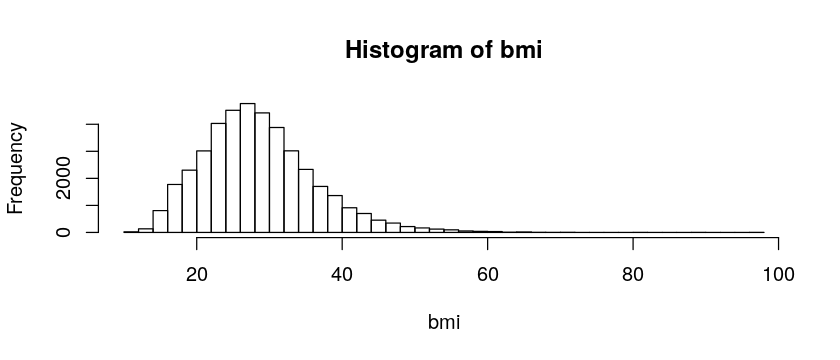

In [290]:
bmi <- Stroke_Data$bmi[Stroke_Data$stroke == 0]
hist(bmi, breaks=50)
print(paste0("Population mean: ", round(mean(bmi), 1)))

[1] "Sample mean: 29.9"


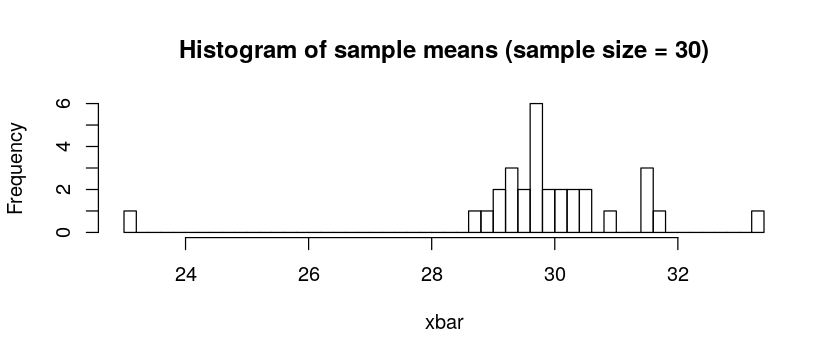

In [291]:
n = 30
sample = sample(bmi, size = n, replace = F)
xbar = rep(0,length(sample))

for (i in 1:length(sample)) {
    xbar[i] = mean(sample[1:i])
}

hist(xbar, breaks=50, main = "Histogram of sample means (sample size = 30)")
print(paste0("Sample mean: ", round(mean(xbar), 1)))

[1] "Sample mean: 29"


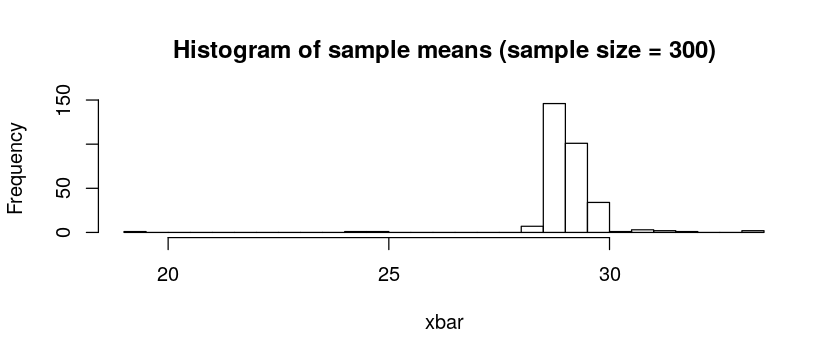

In [292]:
n = 300
sample = sample(bmi, size = n, replace = F)
xbar = rep(0,length(sample))

for (i in 1:length(sample)) {
    xbar[i] = mean(sample[1:i])
}

hist(xbar, breaks=50, main = "Histogram of sample means (sample size = 300)")
print(paste0("Sample mean: ", round(mean(xbar), 1)))

So we could see that distribution of sample means was more likely to look like normal as sample size was increasing.

### Confidence Intervals

> A **confidence interval** is how much uncertainty there is with any particular statistic. Confidence intervals are often used with a margin of error. It tells you how confident you can be that the results from a poll or survey reflect what you would expect to find if it were possible to survey the entire population.

> *Source: [StatisticsHowTo](http://www.statisticshowto.com/probability-and-statistics/confidence-interval/)*

The probability that the random interval $X_n \pm Z_{1-\frac{\alpha}{2}}\frac{\sigma}{\sqrt{n}}$ contains $\mu$ is approximately 95%, where $Z_{1-\frac{\alpha}{2}}$ is the $(1-\frac{\alpha}{2})$ quantile of the standard normal distribution ($\mu=0, \sigma = 1$). This is called 95% CI for $\mu$.

Let's look at example from ideal world where we know the population distribution:

[1] "Population mean: 10.1"
[1] "Population standard error: 5"


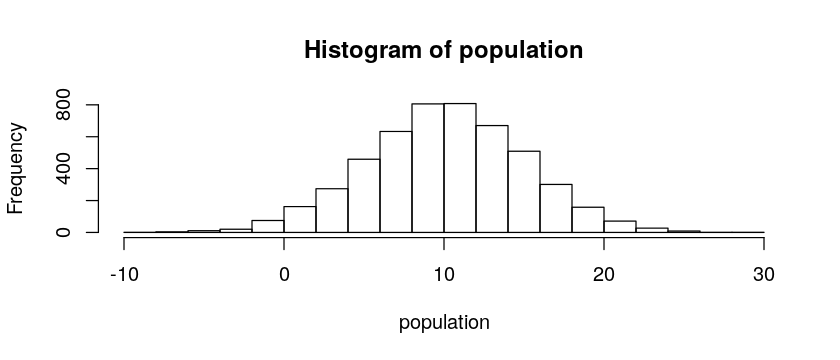

In [245]:
population <- rnorm(5000, 10, 5)
hist(population, breaks = 25)
print(paste0("Population mean: ", round(mean(population), 1)))
print(paste0("Population standard error: ", round(sd(population), 1)))

In [248]:
n=250
sample <- sample(population, size=n, replace = F)
print(paste0("Sample mean: ", round(mean(sample), 1)))
print(paste0("Sample standard error: ", round(sd(sample), 1)))

[1] "Sample mean: 9.6"
[1] "Sample standard error: 5"


[1] "With 95% confidence we can say that population mean is in interval [9; 10.2]"


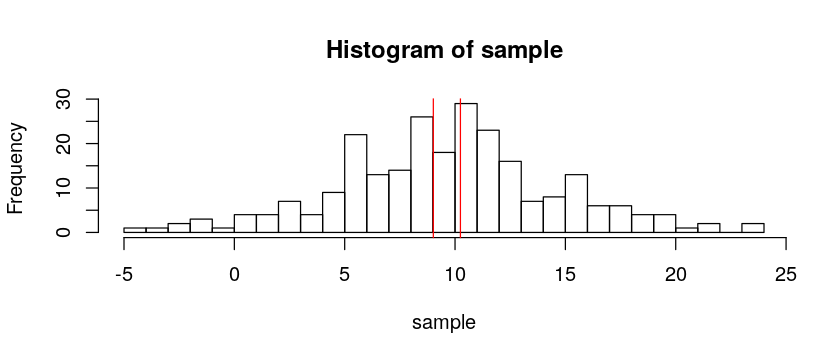

In [253]:
# caclulation 95% CI
alpha = 0.05
quant <- 1 - alpha/2
Z_score <- qnorm(quant, lower.tail=TRUE)
lower <- mean(sample) - Z_score * sd(population) / sqrt(n)
upper <- mean(sample) + Z_score * sd(population) / sqrt(n)

hist(sample, breaks = 25)
abline(v=lower, col="red")
abline(v=upper, col="red")
print(paste0("With 95% confidence we can say that population mean is in interval [", round(lower,1), "; ", round(upper,1), "]"))

But, as said before, we usually don't know the distribution of population. In this case we must rely on sample standard deviations and **T-scores**. T-scores come from T-distributions, which help us account for error that occurs when we sample from a population. We use a different T-distribution to calculate cumulative probabilites depending on our degrees of freedom.

**Confidence interval for the mean using t-distribution:**
\begin{align}
\bar{X} \pm t_{n-1,1-\frac{\alpha}{2}}\frac{s}{\sqrt{n}}
\end{align}

$(n-1)$ - degrees of freedom, $n$ - sample size.

*Note that if we don't know real value of population standard error, we use sample st.error.*

Let's come back to our dataset and find the confidence interval for the mean value of **BMI** for the whole population based on our sample (*sample = dataset itself*).

[1] "With 95% confidence we can say that population mean is in interval [28.5; 28.7]"


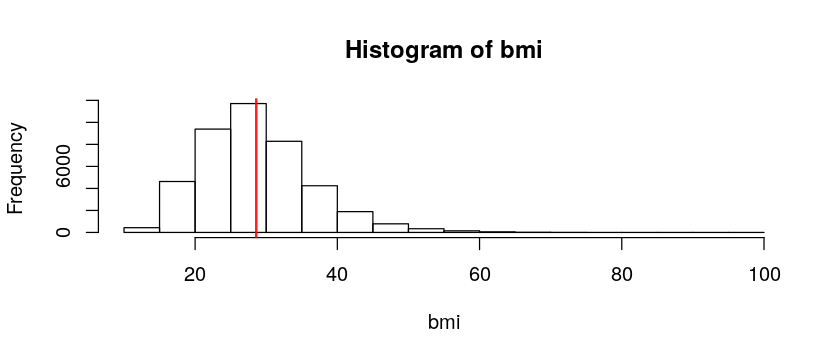

In [269]:
bmi <- Stroke_Data$bmi
X_bar <- mean(bmi)
s <- sd(bmi)
n <- length(bmi)
alpha = 0.05
t_score <- qt(1-alpha/2, n-1)

lower <- X_bar - t_score * s / sqrt(n)
upper <- X_bar + t_score * s / sqrt(n)

hist(bmi, breaks = 25)
abline(v=lower, col="red")
abline(v=upper, col="red")
print(paste0("With 95% confidence we can say that population mean is in interval [", round(lower,1), "; ", round(upper,1), "]"))

Note how narrow the CI is. This is due the large sample size (almost 42k). Look what will happen if we had much smaller sample:

[1] "With 95% confidence we can say that population mean is in interval [27.9; 30.9]"


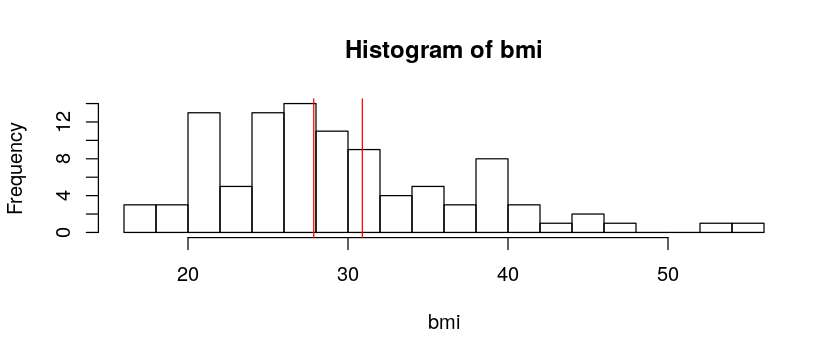

In [270]:
bmi <- Stroke_Data$bmi
bmi <- sample(bmi, size = 100, replace = F) # keep just 100 observations
X_bar <- mean(bmi)
sigma <- sd(bmi)
n <- length(bmi)
alpha = 0.05
t_score <- qt(1-alpha/2, n-1)

lower <- X_bar - t_score * sigma / sqrt(n)
upper <- X_bar + t_score * sigma / sqrt(n)

hist(bmi, breaks = 25)
abline(v=lower, col="red")
abline(v=upper, col="red")
print(paste0("With 95% confidence we can say that population mean is in interval [", round(lower,1), "; ", round(upper,1), "]"))

#### Couple of words about t-distribution

> The **T distribution** (also called Student’s T Distribution) is a family of distributions that look almost identical to the normal distribution curve, only a bit shorter and fatter. The t distribution is used instead of the normal distribution when you have small samples (n < 30). The larger the sample size, the more the t distribution looks like the normal distribution. 

> *Source: [StatisticsHowTo](http://www.statisticshowto.com/probability-and-statistics/t-distribution/)*

![](https://i2.wp.com/www.real-statistics.com/wp-content/uploads/2012/11/t-distribution-chart.png?resize=439%2C264)

## *t* and F tests

In this part we will look at how we can compare independent groups.

### Introduction to t-test and confidence intervals

>The **t-test** (also called **Student’s T-Test**) compares two averages (means) and tells you if they are different from each other. The t-test also tells you how significant the differences are; In other words it lets you know if those differences could have happened by chance.

>*Source: [Statistics How To](http://www.statisticshowto.com/probability-and-statistics/t-test/)*

Assume we have two sets of iid random variables:

$X_1,...,X_n \sim N(\mu_x, \sigma^2)$;

$Y_1,...,Y_n \sim N(\mu_y, \sigma^2)$.

$100(1-\alpha$)% CI for the difference between means of this two sets is:

\begin{gather}
\bar{X} - \bar{Y} \pm t_{n_X+n_Y-2, 1-\frac{\alpha}{2}} S_{n, pooled}(\frac{1}{n_X} + \frac{1}{n_Y})^\frac{1}{2} \\
S^2_{n, pooled} = \frac{(n_X-1)\sigma^2 + (n_Y-1)\sigma^2}{n_X + n_Y - 2}
\end{gather}

$S^2_{n, pooled}$ - pooled variance estimator, mixture of the group variances, placing greater weight on whichever has a larger sample size.

If $\sigma^2_X \neq \sigma^2_Y$, then:
\begin{gather}
\bar{X} - \bar{Y} \pm t_{n_X+n_Y-2, 1-\frac{\alpha}{2}} (\frac{S^2_X}{n_X} + \frac{S^2_Y}{n_Y})^\frac{1}{2} \\
\end{gather}

Let's assume that we want to check whether the difference in age for people who had stroke and who didn't is significant. To do that we can run a **t-test** to find out. First, lets visually inspect the distribution of **Age** by **Stroke** outcome.

In [293]:
Stroke_Data %>%
    mutate(group = case_when(
        (stroke == 1) ~ "Stroke",
        (stroke == 0) ~ "No Stroke")) %>%
    group_by(group) %>%
    summarise(count = length(age),
              mean = round(mean(age)),
              variance = round(var(age),2))

group,count,mean,variance
No Stroke,41288,41,499.90
Stroke,643,68,147.97


What we can see is that average age for having a stroke is much higher (which should not come as a big surprise). If we compare the average values of two groups we will get: 
\begin{align} 
\mu_0- \mu_1 = 41 - 68 = -27 
\end{align}

Our hypothesis for **t-test** look like this:

* $H_0$: there is no difference in mean between two groups. $\mu_0 = \mu_1$

* $H_1$: there is a difference in mean between two groups. $\mu_0 \neq \mu_1$

Now we can just have to run `t.test` function which is built in in R and find out if our difference in means can be considered as significant or it's just a random chance. We can not use paired t-test vecause our groups have different sample size, so we have to set `paired = FALSE` (which comes as default). Another parameter `var.equal` should be also set to `FALSE` since variances between groups are not equal. 

In [211]:
t.test(age~stroke, 
       data=Stroke_Data,
       var.equal = FALSE,
       paired = FALSE,      
       conf.level = 0.95)


	Welch Two Sample t-test

data:  age by stroke
t = -54.922, df = 711.3, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -27.99661 -26.06408
sample estimates:
mean in group 0 mean in group 1 
       41.42688        68.45723 


Confidence interval of mean differences is: [-28; -26]. This does not include 0, so we **reject** null hypothesis and we say that there is a significance difference between group means with confidence level of 95%. In other words, **we are 95% confident that stroke is more likely to happen to older people**.

This may seems unclear - we had two samples, calculated the difference of their averages. This difference was far away from 0, so why did we still have to run t-test to check fot significance? The answer is that the size of confidence interval depends on the sample size (the higher observations we have the more confident we can be). Let's run an another example with less amount of observations.

In [212]:
example <- Stroke_Data %>%
    select(stroke, age) 

#I will fill out data frame with unreal values just for example
example  <- example[1:50,]
example$stroke[1:25]  <- 0
example$stroke[26:50] <- 1

example %>% group_by(stroke) %>%
    summarise(count = length(age),
              mean_age = round(mean(age)),
              variance = round(var(age),2))

stroke,count,mean_age,variance
0,25,49,509.62
1,25,40,497.96


In [213]:
t.test(age~stroke, 
       data=example,
       var.equal = FALSE,
       paired = FALSE,      
       conf.level = 0.95)


	Welch Two Sample t-test

data:  age by stroke
t = 1.3799, df = 47.994, p-value = 0.174
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -4.00454 21.52454
sample estimates:
mean in group 0 mean in group 1 
          49.04           40.28 


In this case difference was 9, which also can be considered as "away from zero", but confidence interval is too wide [-4; 21]. It includes 0 value, so we can not be so sure, that Age is not related to Stroke outcome based on this sample.

### F test

It cab be a difficult task to assume wether the variances between two groups are different or not. We need to provide evidence against the assumption that the true variances are equal. And to do this we need to obtain the distribution of the ratio of variances in group 1 and 2: $\sigma^2_1/\sigma^2_2$.

we always test that the population variances are equal when running an F Test. In other words, we always assume that the variances are equal to 1. Therefore, null hypothesis will always be that the variances are equal.

Test statistic: $F=\frac{\sigma^2_1}{\sigma^2_2}$.

The hypothesis that the two variances are equal is rejected if:

One-tailed test ($> or <$):

\begin{gather}
F > F_{\alpha,n_1-1,n_2-1} \\
F < F_{1- \alpha,n_1-1,n_2-1}
\end{gather}

Two-tailored test ($\neq$):

\begin{gather}
F > F_{\alpha/2,n_1-1,n_2-1} \\
F < F_{1- \alpha/2,n_1-1,n_2-1}
\end{gather}

where $F_{\alpha,n_1-1,n_2-1}$ is the critical value of the $F$ distribution with $(n_1-1)$ and $(n_2-1)$ degrees of freedom and a significance level of $\alpha$.

Let's look back at our example with the distribution of **Age** by **Stroke** outcome:

In [296]:
Stroke_Data %>%
    mutate(group = case_when(
        (stroke == 1) ~ "Stroke",
        (stroke == 0) ~ "No Stroke")) %>%
    group_by(group) %>%
    summarise(count = length(age),
              variance = round(var(age),2))

group,count,variance
No Stroke,41288,499.90
Stroke,643,147.97


In [307]:
# caclulate the ratio of variances
F <- var(Stroke_Data$age[Stroke_Data$stroke == 0]) / var(Stroke_Data$age[Stroke_Data$stroke == 1])
print(paste0("Test statistic (ratio of variances): ", round(F,2)))

[1] "Test statistic (ratio of variances): 3.38"


In [308]:
# get the clitical values for the F distribution
round(qf(c(0.025,0.975),643-1,41288-1),digits=2)

[1] 0.89 1.11

\begin{gather}
F=3.38 > F_{1-\alpha/2,n_1-1,n_2-1}=0.9 
\end{gather}

So we can reject the null hypothesis that the variances between two groups are equal.

We can build the 95% confidence interval for the ratio of variances:
\begin{gather}
\frac{S^2_1/S^2_2}{F_{1-\alpha/2,n_1-1,n_2-1}} < \frac{\sigma^2_1}{\sigma^2_1} < \frac{S^2_1/S^2_2}{F_{\alpha/2,n_1-1,n_2-1}}
\end{gather}

In [309]:
lower <- F/qf(c(0.025,0.975),643-1,41288-1)[2]
upper <- F/qf(c(0.025,0.975),643-1,41288-1)[1]

print(paste0("95% of Confidence interval is [", round(lower,2), "; ", round(upper,2), "]."))

[1] "95% of Confidence interval is [3.03; 3.78]."


And again, interval does not include **1** so we can reject the null hypothesis.

There is a built-in function in R which can compute F-statistic and confidence intervals: `var.test`

In [306]:
var.test(age~stroke, data = Stroke_Data)


	F test to compare two variances

data:  age by stroke
F = 3.3785, num df = 41287, denom df = 642, p-value < 2.2e-16
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 3.016555 3.761306
sample estimates:
ratio of variances 
           3.37849 
